In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os, sys, shutil, copy, time, random
from functools import partial

import sys
sys.path.append("/atlas/u/chenlin/autumn2020/RegressionConstraint")
from sustain_dataset import *
from models import *
from utils import *

In [2]:
class Args:
    def __init__(self):
        self.log_root = '/atlas/u/chenlin/autumn2020/RegressionConstraint/runs/unbiased'
        self.dataset = "poverty" #"gdp"

        self.train_bias_y = False
        self.train_bias_f = False
        self.train_cons = False
        self.train_calib = False
        self.re_calib = True
        self.re_bias_f = True
        self.re_bias_y = True

        # Modeling parameters
        self.model = 'linear' #'big'
        self.learning_rate = 1e-3
        self.batch_size = 1024
        self.num_bins = 0
        self.knn = 100

        # Run related parameters
        self.gpu = 1
        self.num_epoch = 500
        self.run_label = 0
        self.num_run = 10

args = Args()

device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [3]:
args.knn = 200
class RecalibratorBias:
    def __init__(self, model, data, args, train=True, axis='label', verbose=False):
        self.axis = axis
#         self.flow = deeper_flow(layer_num=5, feature_size=20).to(args.device) 
        self.flow = NafFlow().to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        
        k = args.knn
        assert k % 2 == 0
        
        inputs, labels = data
        inputs = inputs.to(args.device)
        labels = labels.to(args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                outputs = model(inputs).flatten()

                if axis == 'label':
                    ranking = torch.argsort(labels)
                else:
                    assert axis == 'prediction'
                    ranking = torch.argsort(outputs)

                sorted_labels = labels[ranking]
                sorted_outputs = outputs[ranking]

                smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                            weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                            padding=0).flatten()
                smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                           weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                           padding=0).flatten()
                
                adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                loss_bias.backward()
                flow_optim.step()

                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
#        if self.axis == 'label':
#             adjusted_output = self.flow.invert(original_y.view(-1, 1))
#         else:
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)
    

In [4]:
class Recalibrator:
    # This class is untested 
    def __init__(self, model, data, args, train=True, re_calib=False, re_bias_f=False, re_bias_y=False, verbose=False):
        self.args = args
        self.re_calib = re_calib
        self.re_bias_f = re_bias_f 
        self.re_bias_y = re_bias_y
        self.model = model  # regression model        
        self.flow = NafFlow(feature_size=40).to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        # flow_scheduler = torch.optim.lr_scheduler.StepLR(flow_optim, step_size=100, gamma=0.9)

        k = args.knn
        assert k % 2 == 0
        assert re_calib or re_bias_f or re_bias_y 
        
        inputs, labels = data
        inputs = inputs.to(self.args.device)
        labels = labels.to(self.args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                loss_all = 0.0
                outputs = model(inputs).flatten()

                for objective in range(2):
                    if objective == 0 and self.re_bias_f:
                        ranking = torch.argsort(outputs)
                    elif objective == 1 and self.re_bias_y:
                        ranking = torch.argsort(labels)
                    else:
                        continue
                    sorted_labels = labels[ranking]
                    sorted_outputs = outputs[ranking]

                    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                                padding=k // 2).flatten()
                    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                               padding=k // 2).flatten()
                    adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                    loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias 

                if re_calib:
                    labels = torch.sort(labels.flatten())[0]
                    outputs = torch.sort(outputs.flatten())[0]
                    adjusted_outputs, _ = self.flow(outputs.view(-1, 1))
                    loss_bias = (labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias

                loss_all.backward()
                flow_optim.step()
                # flow_scheduler.step()
                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)


In [5]:
def plot_knn(model, data, args, axis='label'):
    k = args.knn
    assert k % 2 == 0

    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs).flatten()

    if axis == 'label':
        ranking = torch.argsort(labels)
    else:
        assert axis == 'prediction'
        ranking = torch.argsort(outputs)

    sorted_labels = labels[ranking]
    sorted_outputs = outputs[ranking]

    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                padding=k // 2).flatten()
    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                               padding=k // 2).flatten()
    return smoothed_labels[k//2+1:-k//2-1], smoothed_outputs[k//2+1:-k//2-1]

def plot_calibration(model, data, args):
    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(inputs)
    
    labels, _ = torch.sort(labels.flatten())
    outputs, _ = torch.sort(outputs.flatten())
    return labels, outputs

def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

In [6]:
def tax_utility(difference, beta=1.):
    # difference: y_0 - pred
    return beta * difference


def compute_utility(model, test_dataset, groundtruth=False, a=torch.relu, r=torch.log, y_0=0.3):
    inputs, labels = test_dataset[:]
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs).reshape(-1)
    labels = labels.reshape(-1)
    finacial_aid = a(y_0 - pred)
    true_aid = a(y_0 - labels) 
    after_finacial_aid = labels + finacial_aid
#     utility = r(2.+after_finacial_aid) # worked well
#     utility = r(3.+after_finacial_aid)
    utility = r(1e-6+after_finacial_aid)
    utility = utility.mean(dim=0)
    if not groundtruth:
        return utility.data.item(), finacial_aid.sum().data.item()
    return utility.data.item(), true_aid.data.cpu() - finacial_aid.data.cpu()


# original
def plot_errbar_original(ax, x, y, c=None, label=None):
    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    ax.plot(x, mean, label=label, c=c, linewidth=2.)
    ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)

    
from scipy.interpolate import interp1d
def plot_errbar(ax, x, y, x1=600, x2=2000, c=None, label=None):
    for i in range(y.shape[1]):
        f2 = interp1d(x[:, i], y[:, i], kind='linear')
        y[:, i] = f2(np.linspace(x1, x2, len(x)))

    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    x = np.linspace(x1, x2, len(mean))
    ax.plot(x, mean, label=label, c=c, linewidth=3.)
    return x, mean
    # ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)
    
    
def compute_y0(testdata, total_aid=500, small_y0=-0.5, large_y0=2., act=torch.relu, r=torch.log):
    y0_array = []
    total_array = []
    # sample points of the function
    for y0 in np.linspace(small_y0, large_y0, 100):
        u, a = compute_utility(model, test_dataset, y_0=y0, a=act, r=r)
        total_array.append(a)
        y0_array.append(y0)
    total_array = np.array(total_array)
    y0_array = np.array(y0_array)
     # fit the function
    f2 = interp1d(total_array, y0_array, kind='linear')
    y0_pred = f2(total_aid)
    return y0_pred  

In [7]:
from scipy.interpolate import interp1d
def plot_errbar_div(ax, x, y, x1=10, x2=60, c=None, label=None, require_div=False, y_0=1.):
    for i in range(y.shape[1]):
        f2 = interp1d(x[:, i], y[:, i], kind='linear')
        y[:, i] = f2(np.linspace(x1, x2, len(x)))

    mean = np.mean(y, axis=1)
#     print(mean)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    x = np.linspace(x1, x2, len(mean))

    if require_div:
        ax.plot(x, mean/y_0, label=label, c=c, linewidth=3.)
    # ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)
    else:
        ax.plot(x, mean/mean, label=label, c=c, linewidth=3.)
    return x, mean
    
    

poverty_knn/2009-11_tanzania_recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-20-run=0


/sailhome/chenlin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/sailhome/chenlin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWa

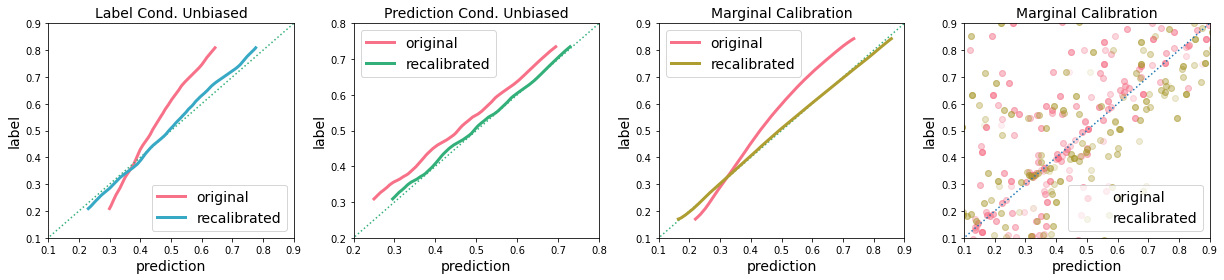

In [8]:
args.knn = 20 #10 #20
utility_points = 100
linewidth = 3
args.model = "small" #"linear"
plot_lim = [0.1, 0.9]
palette = sns.color_palette('husl', 5)
run_labels = np.arange(0, 1, 1)

test_utility = np.zeros((utility_points, len(run_labels)))
test_labels = np.zeros((utility_points, len(run_labels)))

labels_bias = None
for run_label in run_labels:
#     args.name = '%s_knn/2009-11_uganda_recalibration_model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
    args.name = '%s_knn/2009-11_tanzania_recalibration_model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
            (args.dataset, args.model,
             args.train_bias_y, args.train_bias_f, args.train_cons, args.train_calib, args.re_calib,
             args.re_bias_f, args.re_bias_y,
             args.batch_size, args.num_bins, args.knn, run_label)

    args.log_dir = os.path.join(args.log_root, args.name)
    if not os.path.isdir(args.log_dir):
        print("dir not exist {}".format(args.name))
        continue
    print(args.name)

    ckpt = torch.load(os.path.join(args.log_dir, "ckpt.pth"))
    train_dataset = ckpt[1]
    test_dataset = ckpt[2]
    val_dataset = ckpt[3]

    # Define model and optimizer
    model = model_list[args.model](train_dataset.x_dim).to(device)
    # model = model_list[args.model](train_dataset.x_dim, act=F.tanh).to(device)
    model.load_state_dict(ckpt[0])

#                     args.knn = 50
    recalibrator_bias_f = RecalibratorBias(model, val_dataset[:], args, train=False, axis='prediction', verbose=True)
    recalibrator_bias_y = RecalibratorBias(model, val_dataset[:], args, train=False, axis='label', verbose=True)
    recalibrator_calib = Recalibrator(model, val_dataset[:], args, train=False, re_calib=True, verbose=True)

    recalibrator_bias_f.flow.load_state_dict(ckpt[5])
    recalibrator_bias_y.flow.load_state_dict(ckpt[6])
    recalibrator_calib.flow.load_state_dict(ckpt[7])


    model.eval()
#                     import seaborn as sns
#                     palette = sns.color_palette('husl', 3)

#                     plot_lim = [-1.2, 1.6]
    fontsize = 14
    x = torch.linspace(val_dataset[:][1].min(), val_dataset[:][1].max(), 200).to(device)
    with torch.no_grad():
        plt.figure(figsize=(17, 4))
        model.recalibrator = None

        plt.subplot(1, 4, 2) #1
        labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
#                         import pdb
#                         pdb.set_trace()
        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original', linewidth=linewidth) 
        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
        plt.xlabel('prediction', fontsize=fontsize)
        plt.ylabel('label', fontsize=fontsize)
#         plot_lim = [-1., 1.]
        plot_lim = [0.2, 0.8]
        plt.xlim(plot_lim)
        plt.ylim(plot_lim)

        plt.subplot(1, 4, 1) #2
        labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
#         plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[0], label='original', linewidth=linewidth)
        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original', linewidth=linewidth)
        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
#         plt.xlabel('label', fontsize=fontsize)
#         plt.ylabel('prediction', fontsize=fontsize)
        plt.xlabel('prediction', fontsize=fontsize) 
        plt.ylabel('label', fontsize=fontsize)
#         plot_lim = [-1., 1.]
        plot_lim = [0.1, 0.9]
        plt.xlim(plot_lim)
        plt.ylim(plot_lim)

        plt.subplot(1, 4, 3)
        labels, outputs = plot_calibration(model, test_dataset[:], args)
        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original', linewidth=linewidth)
        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
        plt.xlabel('prediction', fontsize=fontsize) 
        plt.ylabel('label', fontsize=fontsize)
#         plot_lim = [-1.2, 1.9]                       
        plt.xlim(plot_lim)
        plt.ylim(plot_lim)


        plt.subplot(1, 4, 2) #1
        model.recalibrator = recalibrator_bias_f
        labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[2], label='recalibrated', linewidth=linewidth)
        y = recalibrator_bias_f.adjust(x.view(-1, 1))
#                         plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
        plt.legend(fontsize=fontsize)
        plt.title("Prediction Cond. Unbiased", fontsize=fontsize)

        plt.subplot(1, 4, 1) #2
        model.recalibrator = recalibrator_bias_y
        labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
#         plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[3], label='recalibrated', linewidth=linewidth)
        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[3], label='recalibrated', linewidth=linewidth)
        y = recalibrator_bias_y.adjust(x.view(-1, 1))
#                         plt.plot(y.detach().cpu(), x.cpu(), c=palette[2], label='mapping')
        plt.legend(fontsize=fontsize)
        plt.title("Label Cond. Unbiased", fontsize=fontsize)

        plt.subplot(1, 4, 3)
        model.recalibrator = recalibrator_calib
        labels, outputs = plot_calibration(model, test_dataset[:], args)
        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='recalibrated', linewidth=linewidth)
        y = recalibrator_calib.adjust(x.view(-1, 1))
#                         plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
        plt.legend(fontsize=fontsize)
        plt.title("Marginal Calibration", fontsize=fontsize)

        plt.subplot(1, 4, 4)
        model.recalibrator = None
        inputs, labels = val_dataset[:]
        inputs = inputs.to(args.device)
        labels = labels.to(args.device).flatten()
        outputs = model(inputs)
        adjusted_outputs = recalibrator_calib.adjust(outputs)
        idx = np.random.choice(np.arange(len(labels)), 1000)
        plt.scatter(outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[0], label='original')
        plt.scatter(adjusted_outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[1], label='recalibrated')
        plt.plot([-1., 2.0], [-1., 2.0], linestyle=':')
        plt.xlim(plot_lim)
        plt.ylim(plot_lim)
        plt.xlabel('prediction', fontsize=fontsize) 
        plt.ylabel('label', fontsize=fontsize)
        plt.legend(fontsize=fontsize)
        plt.title("Marginal Calibration", fontsize=fontsize)
        plt.tight_layout()
#                         plt.savefig('plots/recalib_curve.png')

        plt.show()

In [10]:
len(test_dataset)

310